# Bootes III Part 1

**Note: Some results are either preserved as plots or can be loaded in from files. Some cells that do sampling will give slightly different values each time.**

In this part we identify Boo III spectroscopic member stars from the [S5](https://s5collab.github.io) data. Then we use these stars to compute kinematics and metallicity parameters of the system.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import table
from astropy.io import ascii

# Helper functions
from plot_functions import *
from analysis_functions_v2 import *

In [2]:
# Plot settings. params imported from plot_functions
plt.rcParams.update(params)

# Label shortcuts
pmra_label = r'$\mu_{\alpha}$cos($\delta$) [mas yr$^{-1}$]'
pmdec_label = r'$\mu_{\delta}$ [mas yr$^{-1}$]'

# Physical properties for analysis
RA_BOO3, DEC_BOO3 = 209.3, 26.8 # deg
dm_boo3 = distance_to_dm(46.5 * 1000) # this value is from Carlin 2018, https://iopscience.iop.org/article/10.3847/1538-4357/aad8c1#apjaad8c1t3

# Isochrone and distance modulus for analysis later
dartmouth_isochrone = ascii.read('boo3_iso.iso', header_start=8)
parsec_isochrone = ascii.read('parsec_isochrone.txt', header_start=13)

# Just put a bunch of code into one function that gives M92 ridgeline
# We use this as the BHB isochrone paired with the dartmouth one
# Note: this is gr color and g mag (not g and r mags).
gr_iso_BHB, g_iso_BHB = get_BHB_iso_color_n_mag()

# Styx stream track
styx_trace = ascii.read('styx.trace')

## Read in all the data needed

In [3]:
# S5
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5_full = table.Table(hdu_list[1].data)

table_S5_full['decam_g0'], table_S5_full['decam_r0'], table_S5_full['decam_i0'], table_S5_full['decam_z0'] = deredden_mag_S5(table_S5_full)

# Gaia RRL
with fits.open('gaia_rrl_dr3_all.fits') as hdu_list:
    __table_rrl1 = table.Table(hdu_list[1].data)

with fits.open('GaiaDR3_RRLs_withMu_Lite.fits') as hdu_list: # this one has the EBV_SFD
    __table_rrl2 = table.Table(hdu_list[1].data)

table_rrl = table.join(__table_rrl1, __table_rrl2['source_id', 'EBV_SFD'], keys=['source_id'])

## Member selection

In [4]:
# Radius cut
table_S5_cut = angular_radius_cut(table_S5_full, [RA_BOO3, DEC_BOO3], 3)

# Indices for good quality data
sel_S5_quality = ((table_S5_cut['best_sn_1700d'] > 2) | (table_S5_cut['best_sn_580v'] > 4)) & \
                 (table_S5_cut['vel_calib_std'] < 10) & \
                 (table_S5_cut['good_star_pb'] > 0.5)

# Select those good quality data
table_S5_good = table_S5_cut[sel_S5_quality]

Below, the commented cell does the selection, but we've saved that result in the file `boo3_S5_sample.dat`.

In [5]:
# # These two selection criteria were manually determined by examining the plots
# # Here we just put down the final results

# sel_rv_peak = (170 < table_S5_good['vel_calib']) & (table_S5_good['vel_calib'] < 220)
# sel_pm = (-2 < table_S5_good[sel_rv_peak]['pmra']) & (table_S5_good[sel_rv_peak]['pmra'] < -0.5) & \
#          (-1.2 < table_S5_good[sel_rv_peak]['pmdec']) & (table_S5_good[sel_rv_peak]['pmdec'] < -0.6)

# boo3_S5_sample = table_S5_good[sel_rv_peak][sel_pm]

# # ascii.write(boo3_S5_sample, 'boo3_S5_sample.dat', overwrite=True)

In [6]:
boo3_S5_sample = ascii.read('boo3_S5_sample.dat')

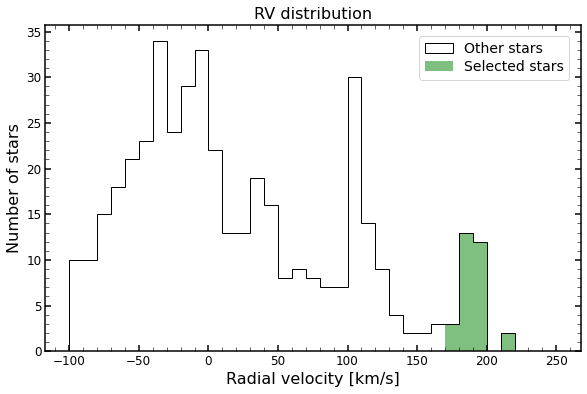

In [6]:
# This is the plot that decided the RV selection

# plt.figure(figsize=(9.6, 6))
# plt.hist(table_S5_good['vel_calib'], bins=35, range=[-100, 250], histtype='step', ec='k', label='Other stars')
# plt.hist(table_S5_good['vel_calib'][sel_rv_peak], bins=35, range=[-100, 250], fc='g', alpha=0.5, label='Selected stars')
# plot_labels('Radial velocity [km/s]', 'Number of stars', 'RV distribution')
# plt.legend(loc="upper right") #, bbox_to_anchor=(1.6, 0.5), prop={'size': 14})
# plt.show()

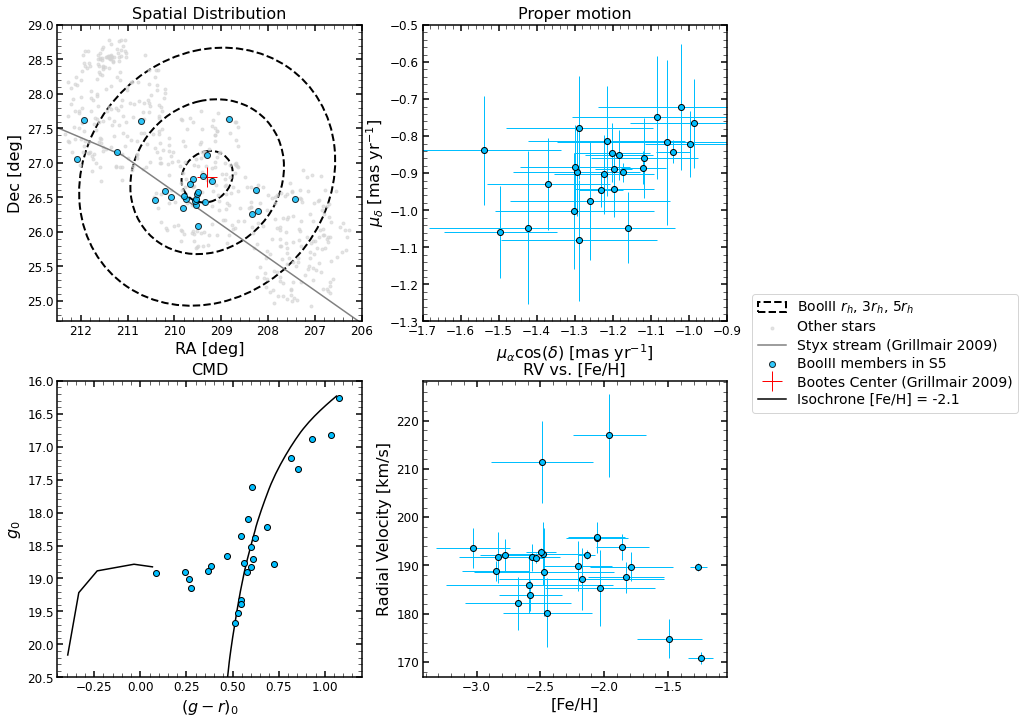

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

plot_rh(ax[0,0])
plot_onsky(fig, ax[0,0], table_S5_good, 'Other stars', marker='.', c='lightgray', zorder=1, alpha=0.6)
ax[0,0].plot(styx_trace['col1'], styx_trace['col2'], 'gray', label='Styx stream (Grillmair 2009)', zorder=1)
plot_onsky(fig, ax[0,0], boo3_S5_sample, 'BooIII members in S5', marker='o', c='deepskyblue', ec='k', zorder=2, alpha=0.8)
ax[0,0].plot(RA_BOO3, DEC_BOO3, '+r', ms=20, label='Bootes Center (Grillmair 2009)', zorder=1)
ax_labels(ax[0,0], 'RA [deg]', 'Dec [deg]', 'Spatial Distribution')
ax[0,0].set_xlim(206, 212.5)
ax[0,0].set_ylim(24.7, 29)
ax[0,0].invert_xaxis()

plot_pm_ax(ax[0,1], boo3_S5_sample, '', fmt='o', c='deepskyblue', mec='k', capsize=0, lw=1)
ax_labels(ax[0,1], pmra_label, pmdec_label, 'Proper motion')
ax[0,1].set_xlim(-1.7, -0.9)
ax[0,1].set_ylim(-1.3, -0.5)

plot_RGB_isochrone(ax[1,0], dartmouth_isochrone['DECam_g'], dartmouth_isochrone['DECam_r'], dm_boo3, 'Isochrone [Fe/H] = -2.1', c='k', zorder=1)
plot_BHB_isochrone(ax[1,0], dm_boo3, c='k')
plot_cmd(fig, ax[1,0], boo3_S5_sample['decam_g0'], boo3_S5_sample['decam_r0'], '', marker='o', c='deepskyblue', ec='k')
ax_labels(ax[1,0], r'$(g-r)_0$', r'$g_0$', 'CMD')
ax[1,0].set_xlim(-0.45, 1.2)
ax[1,0].set_ylim(16, 20.5)
ax[1,0].invert_yaxis()

plot_rv_metallicity_ax(ax[1,1], boo3_S5_sample, '', fmt='o', c='deepskyblue', mec='k', lw=1)
ax_labels(ax[1,1], '[Fe/H]', 'Radial Velocity [km/s]', 'RV vs. [Fe/H]')
#plt.subplots_adjust(top=0.93)
fig.legend(loc="center right", bbox_to_anchor=(1.25, 0.5), prop={'size': 14})
plt.show()

## Compute parameters: 

**(all these cells can be skipped because we have values saved already, just run the cell with the computed values)**

systemic velocity, velocity dispersion, proper motion, metallicity

In [31]:
import vdisp
import corner

In [8]:
samples = vdisp.mcmc(boo3_S5_sample['vel_calib'], boo3_S5_sample['vel_calib_std'], nsteps=1000)

mu = samples[:,0]
sigma = 10**samples[:,1]
samples = np.column_stack((mu, sigma))

In [9]:
# Median, and percentiles
print('mean rv:', np.median(mu) ,  np.percentile(mu, 16) - np.median(mu) , np.percentile(mu, 84) - np.median(mu) )
print('rv dispersion:', np.median(sigma), np.percentile(sigma, 16) - np.median(sigma) , np.percentile(sigma, 84) - np.median(sigma)) 
print('95% dispersion:', np.percentile(sigma, 95)) 

mean rv: 189.6342669972953 -1.5187191849356907 1.510968285529259
rv dispersion: 6.644308968680066 -1.1206514515498602 1.3708510027428185
95% dispersion: 9.111082173930132


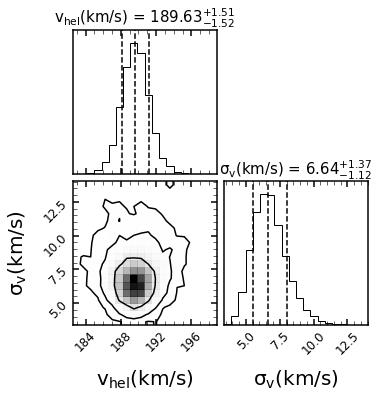

In [10]:
figure = corner.corner(samples,
                       labels=["$\mathrm{v_{hel}(km/s)}$", "$\mathrm{\sigma_{v}(km/s)}$"],
                       quantiles=[0.16, 0.50, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 15},
                       plot_datapoints = False,
                       levels = (0.68, 0.95, 0.997),
                       label_kwargs = dict(fontsize = 20),
                       ls='--', lw=1.5, c='gray', alpha=0)
plt.show()

In [11]:
samples = vdisp.mcmc(boo3_S5_sample['feh50'], boo3_S5_sample['feh_calib_std'], nsteps=1000)

mu = samples[:,0]
sigma = 10**samples[:,1]
samples = np.column_stack((mu, sigma))

In [12]:
print('mean rv:', np.median(mu) ,  np.percentile(mu, 16) - np.median(mu) , np.percentile(mu, 84) - np.median(mu) )
print('rv dispersion:', np.median(sigma), np.percentile(sigma, 16) - np.median(sigma) , np.percentile(sigma, 84) - np.median(sigma)) 
print('95% dispersion:', np.percentile(sigma, 95)) 

mean rv: -2.215416825548138 -0.10915149065525442 0.10206060109723802
rv dispersion: 0.4561804326919726 -0.06891205941290435 0.08808765862927548
95% dispersion: 0.6155017027529072


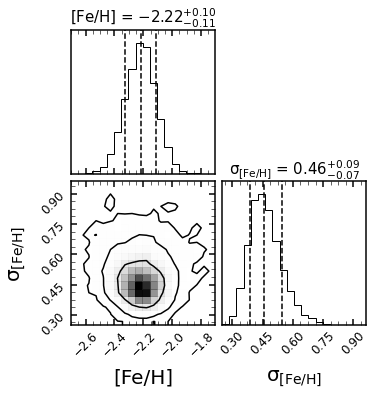

In [13]:
figure = corner.corner(samples,
                       labels=["[Fe/H]", "$\mathrm{\sigma_{ [Fe/H]}}$"],
                       quantiles=[0.16, 0.50, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 15},
                       plot_datapoints = False,
                       levels = (0.68, 0.95, 0.997),
                       label_kwargs = dict(fontsize = 20),
                       ls='--', lw=1.5, c='gray', alpha=0)
plt.show()

100%|██████████| 10500/10500 [01:42<00:00, 102.80it/s]


PMRA -- -1.1645218592411855 0.017356932144749315 0.017230100694489048
PMDEC-- -0.8831086233585828 0.012728666961402957 0.012835262471445064


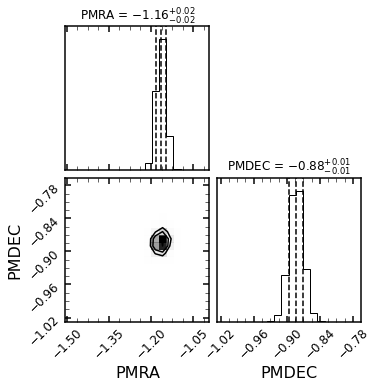

(array([-1.16452186, -1.18187879, -1.14729176]),
 array([-0.88310862, -0.89583729, -0.87027336]))

In [14]:
import mcmc_wrapper

data_in = [boo3_S5_sample['pmra'], boo3_S5_sample['pmdec'], 
           boo3_S5_sample['pmra_error'], boo3_S5_sample['pmdec_error'], boo3_S5_sample['pmra_pmdec_corr']]

data_out = mcmc_wrapper.mcmc_pm(data_in, nsteps=10000)

mcmc_wrapper.plot_pm(data_out)

**Note**: The values below are the MCMC sampling results generated in an earlier version of this work. We have plots saved for them and we use them for orbit and stream modelling. The problem is the actual plots have been overwritten when I ran the notebook again. So now we can't get them anymore. If we need to make nicer plots for the paper, maybe we switch all parameters being used right now? (Since the fit result is just a tiny bit different each time)

In [8]:
rv_mean = 189.10634899860315
rv_mean_err = (1.5489819526171686 + 1.573592942050368) / 2
rv_disp = 6.513531717569297
rv_disp_err = (1.1312875781205616 + 1.400823389241256) / 2

feh_mean = -2.219887971001505
feh_mean_err = (0.10713050982345074 + 0.10337552485484913) / 2
feh_disp = 0.45958674903068764
feh_disp_err = (0.07053684327084114 + 0.087996797358731) / 2

pmra = -1.1645123066918817
pmra_err = (0.01712745145720973 + 0.017118083479818358) / 2
pmdec = -0.8827550800007322 
pmdec_err = (0.012827081957378472 + 0.012792121921749056) / 2

## Find RR Lyrae stars

In [9]:
# Find RR Lyrae stars in this sample
rrl_matched_to_base, sep2d = crossmatch(boo3_S5_sample, table_rrl, get_sep2d=True)

# Give these RRLs their distance moduli (see analysis_functions_v2.py for the code)
add_dm_to_RRLs(rrl_matched_to_base, feh_mean)

# Just append the dm to our data, other things aren't necessarily right now
boo3_sample_rrl = table.hstack([boo3_S5_sample[sep2d < 1*units.arcsec], rrl_matched_to_base['dm']])

# Separate the non RRL stars
boo3_sample_nonrrl = table.setdiff(boo3_S5_sample, boo3_sample_rrl, keys=['source_id'])

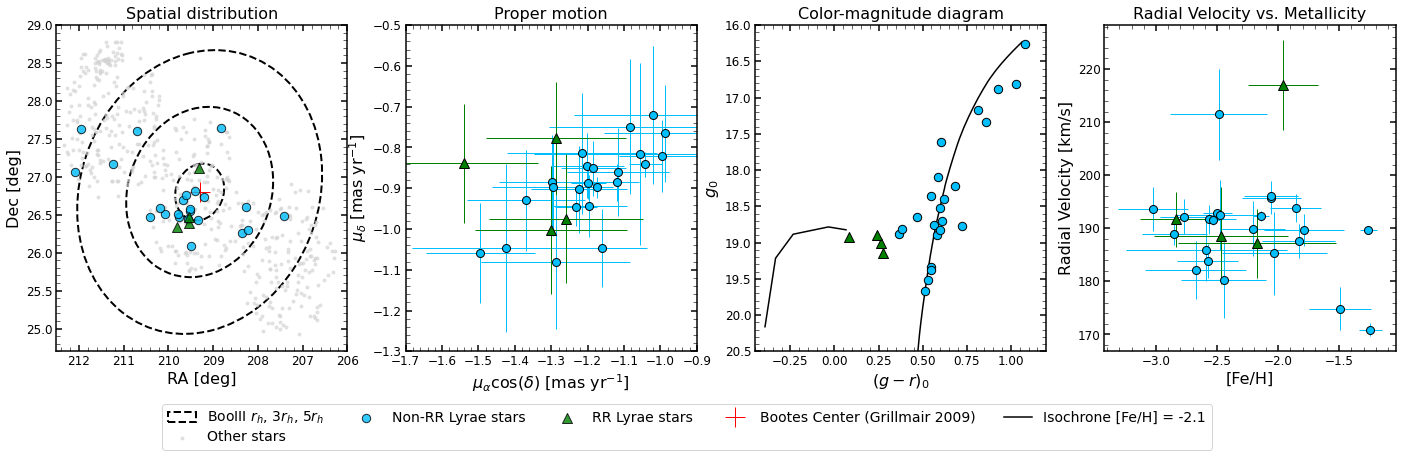

In [10]:
# A nicer plot to be saved with higher resolution

fig, ax = plt.subplots(1, 4, figsize=(24, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1], 'height_ratios': [1]})

plot_rh(ax[0])
plot_onsky(fig, ax[0], table_S5_good, 'Other stars', marker='.', c='lightgray', zorder=1, alpha=0.6)
#ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'gray', label='Styx stream (Grillmair 2009)', zorder=1)
plot_onsky(fig, ax[0], boo3_sample_nonrrl, 'Non-RR Lyrae stars', marker='o', s=70, c='deepskyblue', ec='k', zorder=2, alpha=0.8)
plot_onsky(fig, ax[0], boo3_sample_rrl, 'RR Lyrae stars', marker='^', s=100, c='green', ec='k', zorder=2, alpha=0.8)
ax[0].plot(RA_BOO3, DEC_BOO3, '+r', ms=20, label='Bootes Center (Grillmair 2009)', zorder=1)
ax_labels(ax[0], 'RA [deg]', 'Dec [deg]', 'Spatial distribution')
ax[0].set_xlim(206, 212.5)
ax[0].set_ylim(24.7, 29)
ax[0].invert_xaxis()

plot_pm_ax(ax[1], boo3_sample_nonrrl, '', fmt='o', ms=8, c='deepskyblue', mec='k', capsize=0, lw=1)
plot_pm_ax(ax[1], boo3_sample_rrl, '', fmt='^', ms=10, c='green', mec='k', capsize=0, lw=1)
ax_labels(ax[1], pmra_label, pmdec_label, 'Proper motion')
ax[1].set_xlim(-1.7, -0.9)
ax[1].set_ylim(-1.3, -0.5)

plot_RGB_isochrone(ax[2], dartmouth_isochrone['DECam_g'], dartmouth_isochrone['DECam_r'], dm_boo3, 'Isochrone [Fe/H] = -2.1', c='k', zorder=1)
plot_BHB_isochrone(ax[2], dm_boo3, c='k')
plot_cmd(fig, ax[2], boo3_sample_nonrrl['decam_g0'], boo3_sample_nonrrl['decam_r0'], '', marker='o', s=70, c='deepskyblue', ec='k', zorder=2)
plot_cmd(fig, ax[2], boo3_sample_rrl['decam_g0'], boo3_sample_rrl['decam_r0'], '', marker='^', s=100, c='green', ec='k', zorder=2)
ax_labels(ax[2], r'$(g-r)_0$', r'$g_0$', 'Color-magnitude diagram')
ax[2].set_xlim(-0.45, 1.2)
ax[2].set_ylim(16, 20.5)
ax[2].invert_yaxis()

plot_rv_metallicity_ax(ax[3], boo3_sample_nonrrl, '', fmt='o', ms=8, c='deepskyblue', mec='k', lw=1)
plot_rv_metallicity_ax(ax[3], boo3_sample_rrl, '', fmt='^', ms=10, c='green', mec='k', lw=1)
ax_labels(ax[3], '[Fe/H]', 'Radial Velocity [km/s]', 'Radial Velocity vs. Metallicity')
#plt.subplots_adjust(top=0.93)
fig.legend(loc="center right", bbox_to_anchor=(0.8, -0.05), prop={'size': 14}, ncol=5)

#plt.savefig('s5_base_members.png', dpi=600)
plt.show()

## Some further analysis

The RRL velocities are changing all the time, not good for RV fitting. Will excluding them change our velocity dispersion?

mean rv: 189.0708394005208 -1.549552367388742 1.5435444585125424
rv dispersion: 6.5014894877601925 -1.1051687059969293 1.4284106275482573
95% dispersion: 9.083908768418787


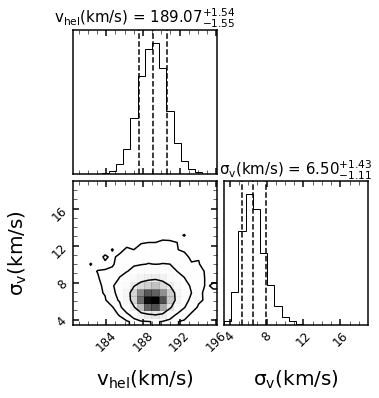

In [13]:
import vdisp
import corner

samples = vdisp.mcmc(boo3_sample_nonrrl['vel_calib'], boo3_sample_nonrrl['vel_calib_std'], nsteps=1000)

mu = samples[:,0]
sigma = 10**samples[:,1]
samples = np.column_stack((mu, sigma))

# Median, and percentiles
print('mean rv:', np.median(mu) ,  np.percentile(mu, 16) - np.median(mu) , np.percentile(mu, 84) - np.median(mu) )
print('rv dispersion:', np.median(sigma), np.percentile(sigma, 16) - np.median(sigma) , np.percentile(sigma, 84) - np.median(sigma)) 
print('95% dispersion:', np.percentile(sigma, 95)) 

figure = corner.corner(samples,
                       labels=["$\mathrm{v_{hel}(km/s)}$", "$\mathrm{\sigma_{v}(km/s)}$"],
                       quantiles=[0.16, 0.50, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 15},
                       plot_datapoints = False,
                       levels = (0.68, 0.95, 0.997),
                       label_kwargs = dict(fontsize = 20),
                       ls='--', lw=1.5, c='gray', alpha=0)
plt.show()

No. It does not have a significant impact to the RV mean.

**Rest assured, the velocity that we use to do modelling is in fact computed from this later step, where we removed the RRLs. Although that difference is probably unnoticeable.**

There are 3 non RRL stars that are RV "outliers" as can be seen in the plots.

Are they the cause for the large velocity dispersion?

In [11]:
# Manually pick them out

i1 = (170 < boo3_sample_nonrrl['vel_calib']) & (boo3_sample_nonrrl['vel_calib'] < 172)
i2 = (172 < boo3_sample_nonrrl['vel_calib']) & (boo3_sample_nonrrl['vel_calib'] < 178)
i3 = (210 < boo3_sample_nonrrl['vel_calib']) & (boo3_sample_nonrrl['vel_calib'] < 220)

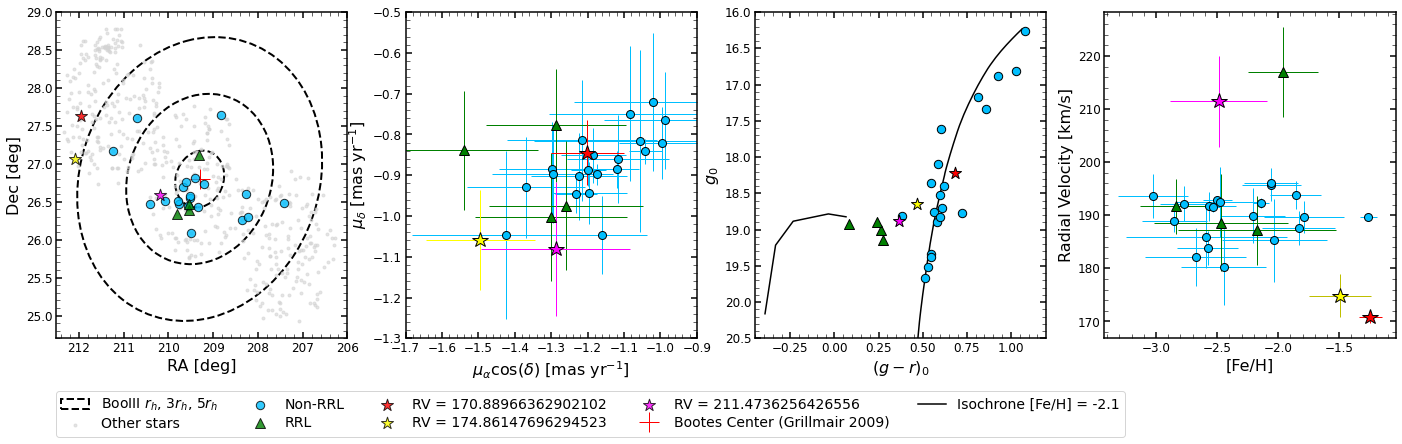

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(24, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1], 'height_ratios': [1]})

plot_rh(ax[0])
plot_onsky(fig, ax[0], table_S5_good, 'Other stars', marker='.', c='lightgray', zorder=1, alpha=0.6)
#ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'gray', label='Styx stream (Grillmair 2009)', zorder=1)
plot_onsky(fig, ax[0], boo3_sample_nonrrl[np.invert(i1|i2|i3)], 'Non-RRL', marker='o', s=70, c='deepskyblue', ec='k', zorder=2, alpha=0.8)
plot_onsky(fig, ax[0], boo3_sample_rrl, 'RRL', marker='^', s=100, c='green', ec='k', zorder=2, alpha=0.8)
plot_onsky(fig, ax[0], boo3_sample_nonrrl[i1], 'RV = '+str(boo3_sample_nonrrl['vel_calib'][i1][0]), marker='*', s=160, c='red', ec='k', zorder=2, alpha=0.8)
plot_onsky(fig, ax[0], boo3_sample_nonrrl[i2], 'RV = '+str(boo3_sample_nonrrl['vel_calib'][i2][0]), marker='*', s=160, c='yellow', ec='k', zorder=2, alpha=0.8)
plot_onsky(fig, ax[0], boo3_sample_nonrrl[i3], 'RV = '+str(boo3_sample_nonrrl['vel_calib'][i3][0]), marker='*', s=160, c='magenta', ec='k', zorder=2, alpha=0.8)
ax[0].plot(RA_BOO3, DEC_BOO3, '+r', ms=20, label='Bootes Center (Grillmair 2009)', zorder=1)
ax_labels(ax[0], 'RA [deg]', 'Dec [deg]', '')
ax[0].set_xlim(206, 212.5)
ax[0].set_ylim(24.7, 29)
ax[0].invert_xaxis()

plot_pm_ax(ax[1], boo3_sample_nonrrl[np.invert(i1|i2|i3)], '', fmt='o', ms=8, c='deepskyblue', mec='k', capsize=0, lw=1)
plot_pm_ax(ax[1], boo3_sample_rrl, '', fmt='^', ms=10, c='green', mec='k', capsize=0, lw=1)
plot_pm_ax(ax[1], boo3_sample_nonrrl[i1], '', fmt='*', ms=16, c='red', mec='k', capsize=0, lw=1)
plot_pm_ax(ax[1], boo3_sample_nonrrl[i2], '', fmt='*', ms=16, c='yellow', mec='k', capsize=0, lw=1)
plot_pm_ax(ax[1], boo3_sample_nonrrl[i3], '', fmt='*', ms=16, c='magenta', mec='k', capsize=0, lw=1)
ax_labels(ax[1], pmra_label, pmdec_label, '')
ax[1].set_xlim(-1.7, -0.9)
ax[1].set_ylim(-1.3, -0.5)

plot_RGB_isochrone(ax[2], dartmouth_isochrone['DECam_g'], dartmouth_isochrone['DECam_r'], dm_boo3, 'Isochrone [Fe/H] = -2.1', c='k', zorder=1)
plot_BHB_isochrone(ax[2], dm_boo3, c='k')
plot_cmd(fig, ax[2], boo3_sample_nonrrl['decam_g0'][np.invert(i1|i2|i3)], boo3_sample_nonrrl['decam_r0'][np.invert(i1|i2|i3)], '', marker='o', s=70, c='deepskyblue', ec='k', zorder=2)
plot_cmd(fig, ax[2], boo3_sample_rrl['decam_g0'], boo3_sample_rrl['decam_r0'], '', marker='^', s=100, c='green', ec='k', zorder=2)
plot_cmd(fig, ax[2], boo3_sample_nonrrl['decam_g0'][i1], boo3_sample_nonrrl['decam_r0'][i1], '', marker='*', s=160, c='red', ec='k', zorder=2)
plot_cmd(fig, ax[2], boo3_sample_nonrrl['decam_g0'][i2], boo3_sample_nonrrl['decam_r0'][i2], '', marker='*', s=160, c='yellow', ec='k', zorder=2)
plot_cmd(fig, ax[2], boo3_sample_nonrrl['decam_g0'][i3], boo3_sample_nonrrl['decam_r0'][i3], '', marker='*', s=160, c='magenta', ec='k', zorder=2)
ax_labels(ax[2], r'$(g-r)_0$', r'$g_0$', '')
ax[2].set_xlim(-0.45, 1.2)
ax[2].set_ylim(16, 20.5)
ax[2].invert_yaxis()

plot_rv_metallicity_ax(ax[3], boo3_sample_nonrrl[np.invert(i1|i2|i3)], '', fmt='o', ms=8, c='deepskyblue', mec='k', lw=1)
plot_rv_metallicity_ax(ax[3], boo3_sample_rrl, '', fmt='^', ms=10, c='green', mec='k', lw=1)
plot_rv_metallicity_ax(ax[3], boo3_sample_nonrrl[i1], '', fmt='*', ms=16, c='red', mec='k', lw=1)
plot_rv_metallicity_ax(ax[3], boo3_sample_nonrrl[i2], '', fmt='*', ms=16, c='yellow', ecolor='y', mec='k', lw=1)
plot_rv_metallicity_ax(ax[3], boo3_sample_nonrrl[i3], '', fmt='*', ms=16, c='magenta', mec='k', lw=1)
ax_labels(ax[3], '[Fe/H]', 'Radial Velocity [km/s]', '')

fig.legend(loc="center right", bbox_to_anchor=(0.75, -0.05), ncol=5, prop={'size': 14})
#plt.savefig('s5_base_members_alt.png', dpi=600)
plt.show()

mean rv: 191.29090101453446 -0.8300475667187186 0.6936699352389724
rv dispersion: 1.918921494989447 -0.7532905120956146 0.9091700111534313
95% dispersion: 3.572600399789873


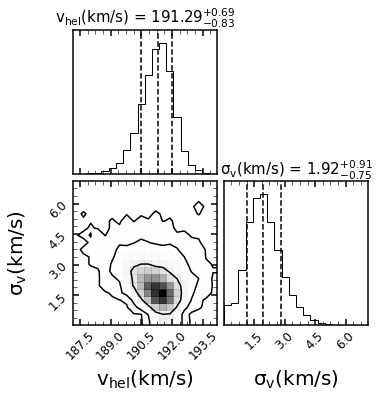

In [49]:
samples = vdisp.mcmc(boo3_sample_nonrrl[np.invert(i1|i2|i3)]['vel_calib'], boo3_sample_nonrrl[np.invert(i1|i2|i3)]['vel_calib_std'], nsteps=1000)

mu = samples[:,0]
sigma = 10**samples[:,1]
samples = np.column_stack((mu, sigma))

# Median, and percentiles
print('mean rv:', np.median(mu) ,  np.percentile(mu, 16) - np.median(mu) , np.percentile(mu, 84) - np.median(mu) )
print('rv dispersion:', np.median(sigma), np.percentile(sigma, 16) - np.median(sigma) , np.percentile(sigma, 84) - np.median(sigma)) 
print('95% dispersion:', np.percentile(sigma, 95)) 

figure = corner.corner(samples,
                       labels=["$\mathrm{v_{hel}(km/s)}$", "$\mathrm{\sigma_{v}(km/s)}$"],
                       quantiles=[0.16, 0.50, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 15},
                       plot_datapoints = False,
                       levels = (0.68, 0.95, 0.997),
                       label_kwargs = dict(fontsize = 20),
                       ls='--', lw=1.5, c='gray', alpha=0)
plt.show()

Velocity dispersion drops drastically! 

It is intuitively obvious because we can visibility tell that those 3 stars are the farthest from the others, and the others are in a tighter group.

But how confident are we to say that these 3 stars are actually members?
And have we found all the possible member stars? This sample first needs to be complete (cover all the possibilities even if some stars are misclassified), and then we can try to make it concise.

Next step we need to account for errors when making cuts. Right now we have very simple box cuts but that is not sufficient.
We need to use a more complete proper motion selection (drawing a convariance matrix ellipse and see if it overlaps with the box cut we made, so that we take into account the errors on the proper motions). Maybe also adjust the RV selection to account for stars that agree with the range cut to within 3$\sigma$.